# Traffic sign detection and classification (with deep learning)
Reset kernel

In [1]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## Dependencies
Install dependencies. Adapt this to your linux distro/windows machine. Don't forget to restart the kernel to update the installed python packages.

In [1]:
%%capture
# Adapt adp-get to your distro
!pip install -U jupyter
!apt-get update && DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv unzip
!pip install opencv-python torchvision torchaudio albumentations kaggle tdqm torchsummary
!pip install --upgrade --quiet jupyter_client ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Download dataset. I've created an account for this task, so please don't abuse this API key, thx.

In [2]:
%%capture
!mkdir -p ~/.kaggle
!echo "{\"username\":\"vcguy2022\",\"key\":\"58a013ff978771be5b85417b3ee3917c\"}"  > /root/.kaggle/kaggle.json
!kaggle datasets download andrewmvd/road-sign-detection
!unzip road-sign-detection -d dataset/;

In [28]:
import cv2 as cv
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import json
import numpy as np
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import xml.etree.ElementTree as ET
from tqdm import tqdm
from utils import plotTrainingHistory
from torchsummary import summary
import matplotlib.pyplot as plt

Define your images and annotations directory here

In [4]:
images_directory = "dataset/images"
annotations_directory = "dataset/annotations"

Load train and val images and shufflte them

In [5]:
# Get train and validation datasets

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)

#displayImage(importImage(train_images_filenames[0])), displayImage(importImage(val_images_filenames[0]))
len(train_images_filenames), len(val_images_filenames)

(613, 264)

Define functions to visualize images

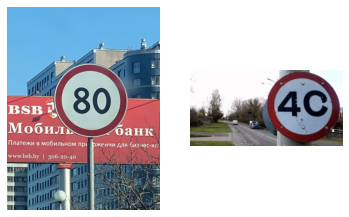

In [6]:
def importImage(name):
    from os import path
    image = cv.imread(path.join(images_directory, name + ".png"))
    return cv.cvtColor(image, cv.COLOR_BGR2RGB)

def displayImage(*names, title=""):
    fig, axs = plt.subplots(nrows=1, ncols=len(names))
    for index, name in enumerate(names):
        axs[index].imshow(importImage(name))
        axs[index].axis('off')
    
    plt.title(title)
    plt.show()

displayImage(train_images_filenames[0], val_images_filenames[0])

## Load Dataset

For this, we define the classes that we want to predict and we define a dataset class, show bellow

In [7]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = importImage(image_filename)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self._get_max_area_class_from_annotion(image_filename)

    def _get_max_area_class_from_annotion(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]

Define transforms

In [8]:
def get_transform(input_size, mean, std):
    train_transform = A.Compose([
        A.RandomResizedCrop(input_size, input_size),
        A.HorizontalFlip(),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    val_transform = A.Compose([
        A.Resize(input_size, input_size),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    return train_transform, val_transform


Get dataloaders according to desired image size, which will vary according to the expected input size of the network

In [9]:
def get_dataloaders(input_size, mean, std):
    train_transform, val_transform = get_transform(input_size, mean, std)
    train_dataset = TrafficSignDataset(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    val_dataset = TrafficSignDataset(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
    return train_dataloader, val_dataloader

Define batch size and num workers

In [10]:
batch_size = 128
num_workers = 0 # How many processes are used to load the data

Define device

In [11]:
num_classes = len(classes)

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Training

We define a model trainer class, which will help us to train each model more easily

In [186]:
MODELS_DIR = "models"

class ModelTrainer:
    def __init__(self, *args):
        if len(args) == 5:
            model, model_name, loss, optimizer, device = args
        elif len(args) == 2:
            ks = ["model", "name", "num_epochs", "loss", "optimizer"]
            model, model_name, num_epochs, loss, optimizer = [args[0][k] for k in ks]
            device = args[1]

        self.model = model
        self.model_name = model_name
        self.curr_epoch = 0
        self.num_epochs = num_epochs # Epochs that each training session will have
        self.loss = loss
        self.optimizer = optimizer
        self.device = device
        self.accuracies = {}

    def predict_data(self, data):
        print("Predicting data")
        preds = []
        actuals = []
        with torch.set_grad_enabled(False):
            for _, (X, y) in enumerate(tqdm(data)):
                pred = self.model(X)
                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred)
                actuals.extend(y)
        return torch.stack(preds, dim=0), torch.stack(actuals, dim=0)

    def _epoch_iter(self, dataloader, is_train):
        if is_train:
            assert self.optimizer is not None, "When training, please provide an optimizer."

        num_batches = len(dataloader)

        if is_train:
            self.model.train()  # put model in train mode
        else:
            self.model.eval()

        total_loss = 0.0
        preds = []
        labels = []

        with torch.set_grad_enabled(is_train):
            for batch, (X, y) in enumerate(tqdm(dataloader)):
                X, y = X.to(self.device), y.to(self.device)

                # Compute prediction error
                pred = self.model(X)
                loss = self.loss(pred, y)

                if is_train:
                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                # Save training metrics
                # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
                total_loss += loss.item()

                probs = F.softmax(pred, dim=1)
                final_pred = torch.argmax(probs, dim=1)
                preds.extend(final_pred.cpu().numpy())
                labels.extend(y.cpu().numpy())

        return total_loss / num_batches, accuracy_score(labels, preds)
    
    def _save_model(self, t, file_name):
        import os
        os.makedirs(MODELS_DIR, exist_ok=True)

        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        
        save_dict = {'model': self.model.state_dict(), 'optimizer': self.optimizer.state_dict(), 'epoch': t}
        torch.save(save_dict, model_path)

        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        with open(acc_path, 'w') as f:
            f.write(json.dumps(self.accuracies))

    def load_model(self, file_name):
        model_path = os.path.join(MODELS_DIR, f'{self.model_name}_{ file_name }.pth')
        acc_path = os.path.join(MODELS_DIR, self.model_name + '_accuracy_history.json')
        dic = torch.load(model_path)
        self.model.load_state_dict(dic['model'])
        self.model.eval()
        
        with open(acc_path, 'r') as f:
            self.accuracies = json.load(f)

        print(f"Loaded { self.model_name } obtained in epoch { dic['epoch'] }")

    def append_history(self, stage, train_data, val_data):
        train_loss, train_acc = train_data
        val_loss, val_acc = val_data
        self.accuracies[stage] = {
            "train": {
                "loss": train_loss,
                "acc": train_acc
            },
            "val": {
                "loss": val_loss,
                "acc": val_acc
            },         
        }

    def reset_accuracy(self):
        self.accuracies = {}

    def train(self, train_dataloader, validation_dataloader, stage):
        # Stage => String identifier of the training iteration. Is used to identify between
        # the same model being trained at different contexts (exº fine tunning)
        accuracies = []
        train_history = {'loss': [], 'accuracy': []}
        val_history = {'loss': [], 'accuracy': []}
        best_val_loss = np.inf
        print("Start training...")

        for _ in range(self.num_epochs):
            t = self.curr_epoch
            print(f"\nEpoch {t}")

            # Train
            train_loss, train_acc = self._epoch_iter(train_dataloader, True)

            print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")

            # Test
            val_loss, val_acc = self._epoch_iter(validation_dataloader, False)
            print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

            # save training history for plotting purposes
            train_history["loss"].append(train_loss)
            train_history["accuracy"].append(train_acc)

            val_history["loss"].append(val_loss)
            val_history["accuracy"].append(val_acc)
            self.append_history(f'{stage}_{t}', (train_loss, train_acc), (val_loss, val_acc))

            # Save model when validation loss improves
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model(f'{stage}_{t}', 'best_model')

            # Save latest model
            self._save_model(f'{stage}_{t}', 'latest_model')
            self.curr_epoch += 1
            
        print("Finished")
        return train_history, val_history

    def freeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze_layers(self):
        for param in self.model.parameters():
            param.requires_grad = True

    def unfreeze_fc(self):
        self.model.fc.weight.requires_grad = True

    def visualize_model(self, val_dataloader, classes, num_images=6): # Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
        was_training = self.model.training
        self.model.eval()
        images_so_far = 0
        fig = plt.figure()

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(val_dataloader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)

                for j in range(inputs.size()[0]):
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    class_names = list(classes.keys())
                    ax.set_title(f'predicted: {class_names[preds[j]]}')
                    cv.imshow(inputs.cpu().data[j])

                    if images_so_far == num_images:
                        self.model.train(mode=was_training)
                        return
            self.model.train(mode=was_training)

The function bellow will plot accuracy of a training session

In [146]:
def plotTrainingHistory(accuracies, session):
    session_accs = filter(lambda x: x.startswith(session), accuracies)
    val_loss, val_acc, train_loss, train_acc = [], [], [], []
    for t in session_accs:
        epoch_acc = accuracies[t]
        train_loss.append(epoch_acc["train"]["loss"])
        train_acc.append(epoch_acc["train"]["acc"])
        val_loss.append(epoch_acc["val"]["loss"])
        val_acc.append(epoch_acc["val"]["acc"])

    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_loss, label='train')
    plt.plot(val_loss, label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_acc, label='train')
    plt.plot(val_acc, label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### ResNet-50
ResNet expects an input size of 224, and expects images to be normalized according to the following mean and std values

In [147]:
input_size = 224
mean, std =[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
train_dataloader, val_dataloader = get_dataloaders(input_size, mean, std)

We define a baseline with 10 epochs, cross entropy loss, and SGD optimizer

In [184]:
resnet_model_trained = models.resnet50(pretrained=True)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_trained.fc.in_features
resnet_model_trained.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_trained.to(device)

resnet = {
    "model": resnet_model_trained,
    "name": 'resnet50_pretrained',
    #"num_epochs": 50,
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(resnet_model_trained.parameters(), lr=1e-2)
}

#summary(resnet["model"], (3, input_size, input_size))

Do **transfer learning** - train only last layer while freezing all others.

resnet50_pretrained_best_model.pth
Loaded resnet50_pretrained obtained in epoch fine_tuning_12


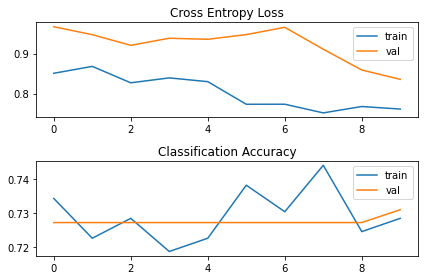

In [187]:
resnet_trainer = ModelTrainer(resnet, device)
# Unfreeze all layers expect last
resnet_trainer.freeze_layers()
resnet_trainer.unfreeze_fc()

def load_model(trainer): # Returns True if success
    import os
    path = os.path.join(MODELS_DIR, trainer.model_name + '_best_model.pth')
    file_exists = os.path.exists(path)
    print(trainer.model_name + '_best_model.pth')
    if not file_exists:
        print("Saved model not found, training instead.")
        return False
    else:
        resnet_trainer.load_model("best_model")
        return True

# Training can be skipped by loading the best model until now
load = True # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)
if not load or need_train:
    resnet_trainer.train(train_dataloader, val_dataloader, "frozen")

plotTrainingHistory(resnet_trainer.accuracies, "frozen")

Perform fine tunning - unfreeze all layers and train with a small learning rate a small number of epochs

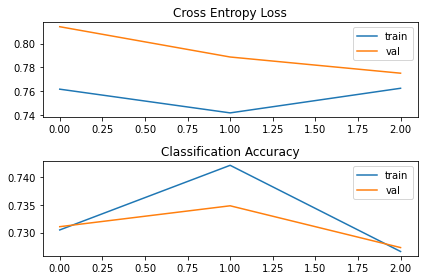

In [188]:
resnet_trainer.optimizer = torch.optim.SGD(resnet_model.parameters(), lr=1e-7)
resnet_trainer.num_epochs = 3 
resnet_trainer.unfreeze_layers()

if need_train: # Train if previous cell has trained too
    resnet_train_history, resnet_val_history = resnet_trainer.train(train_dataloader, val_dataloader, "fine_tuning")

plotTrainingHistory(resnet_trainer.accuracies, "fine_tuning")

Now let's train the network by scratch, with the same hyperparams expect learning rate, which was increased to get to the minima faster.

resnet50_scratch_best_model.pth
Loaded resnet50_scratch obtained in epoch scratch_8


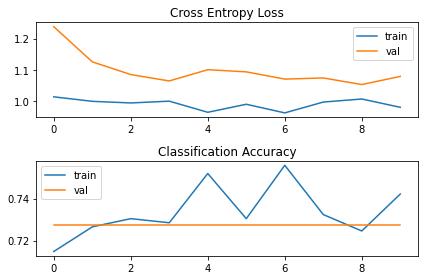

In [194]:
resnet_model_scratch = models.resnet50(pretrained=False)
# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
num_ftrs = resnet_model_scratch.fc.in_features
resnet_model_scratch.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
resnet_model_scratch.to(device)

resnet = {
    "model": resnet_model_scratch,
    "name": 'resnet50_scratch',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),
    "optimizer": torch.optim.SGD(resnet_model.parameters(), lr=0.1)
}

resnet_trainer = ModelTrainer(resnet, device)
# Unfreeze all layers
resnet_trainer.unfreeze_layers()

load = True # Change this to False to force to retrain
if load:
    need_train = (load_model(resnet_trainer) == False)

if not load or need_train:
    resnet_trainer.train(train_dataloader, val_dataloader, "scratch")

plotTrainingHistory(resnet_trainer.accuracies, "scratch")

### VGG-16

In [ ]:
# Load model from torchvision (with pretrained=True)
vgg_model = models.vgg16(pretrained=True)
# Change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg_model.classifier[6] = nn.Linear(4096, num_classes)
vgg_model.to(device)

vgg = {
    "model": vgg_model,
    "name": 'vgg16',
    "num_epochs": 10,
    "loss": nn.CrossEntropyLoss(),  # already includes the Softmax activation
    "optimizer": torch.optim.SGD(vgg_model.parameters(), lr=1e-3)
}
print(vgg)

Only train last layers

Train from scratch

In [ ]:
vg_trainer = ModelTrainer(vgg, device)
vgg_train_history, vgg_val_history = vg_trainer.train(train_dataloader, val_dataloader)

plotTrainingHistory(vgg_train_history, vgg_val_history)